#### Import necessary packages

In [62]:
import pandas as pd
import numpy as np
import math
import pickle
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

#### Load the datasets

In [59]:
X_train=pd.read_csv("X_train.csv")
y_train=pd.read_csv("y_train.csv")

In [35]:
X_val=pd.read_csv("X_val.csv")
y_val=pd.read_csv("y_val.csv")

In [7]:
X_test=pd.read_csv("X_test.csv")
y_test=pd.read_csv("y_test.csv")

In [8]:
sample_submission1=pd.read_csv("recruit-restaurant-visitor-forecasting (1)/sample_submission.csv/sample_Submission.csv")

In [58]:
X_train

,week,month,holiday_flg,mean_visitors,max_visitors,count_observations,air_genre_name,air_area_name,visitors_per_area,restaurants_per_area,rv1_x,date_int,air_store_id2
0,2,1,0,23.843750,57.0,64.0,4.0,62.0,2488.0,56.0,-1.0,20160113,603
1,3,1,0,20.292308,54.0,65.0,4.0,62.0,2488.0,56.0,-1.0,20160114,603
2,4,1,0,34.738462,61.0,65.0,4.0,62.0,2488.0,56.0,-1.0,20160115,603
3,5,1,0,27.651515,53.0,66.0,4.0,62.0,2488.0,56.0,-1.0,20160116,603
4,0,1,0,13.754386,34.0,57.0,4.0,62.0,2488.0,56.0,-1.0,20160118,603
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235547,5,3,0,5.289474,8.0,38.0,11.0,72.0,269.0,14.0,-1.0,20170325,98
235548,0,3,0,4.794118,8.0,34.0,11.0,72.0,269.0,14.0,-1.0,20170327,98
235549,1,3,0,5.615385,11.0,39.0,11.0,72.0,269.0,14.0,-1.0,20170328,98
235550,2,3,0,6.575000,25.0,40.0,11.0,72.0,269.0,14.0,-1.0,20170329,98


In [2]:
# Root Mean Squared logarithemic Error
def rmsle_score(y,y_pred): 
    """
    Compute the Root Mean Squared Log Error for prediction y_pred and targets y

    Args:
        y_pred - numpy array containing log of predictions 
        y - numpy array containing log of targets 
    """
    # to get anti- logs
    y = np.expm1(y)
    y_pred = np.expm1(y_pred)
    
    return np.sqrt(np.square(np.log(y_pred + 1) - np.log(y + 1)).mean())

# scoring function
score = make_scorer(rmsle_score, greater_is_better=False)

#### Used GridSearchCV to find best hyperparameters

In [29]:
# hyperparameters
parameters = {'n_neighbors':range(1,20,2)}

# model
knn = KNeighborsRegressor(n_jobs=-1)

# cross validation
knn_cv = GridSearchCV(estimator=knn,
                      param_grid=parameters,
                      scoring=score,
                      n_jobs=-1,
                      cv=3,
                      verbose=10,
                      return_train_score=True)
knn_cv.fit(X_train,np.log1p(y_train['visitors']))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.3min remaining:   43.5s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.5min remaining:   27.0s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.8min remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=-1,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': range(1, 20, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(rmsle_score, greater_is_better=False),
             verbose=10)

In [32]:
# saving cross validation results
pd.DataFrame(knn_cv.cv_results_).to_csv('KNN_cv_results.csv')

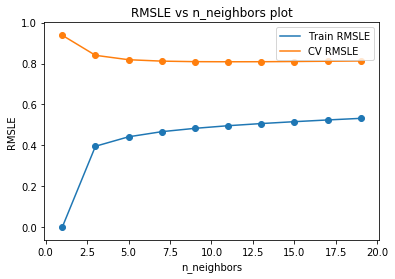

In [33]:
# plotting Score vs hyperparameter plot
cv_results = pd.read_csv('KNN_cv_results.csv')
mean_train_score = -1 * cv_results.mean_train_score.values # -1 is to invert sign 
mean_test_score = -1 * cv_results.mean_test_score.values
n_neighbors = cv_results.param_n_neighbors.values
plt.plot(n_neighbors,mean_train_score,label='Train RMSLE')
plt.plot(n_neighbors,mean_test_score,label='CV RMSLE')
plt.scatter(n_neighbors,mean_train_score)
plt.scatter(n_neighbors,mean_test_score)
plt.xlabel('n_neighbors')
plt.ylabel('RMSLE')
plt.legend()
plt.title('RMSLE vs n_neighbors plot')
plt.show()


In [34]:
knn_cv.best_params_

{'n_neighbors': 11}

In [5]:
knn = KNeighborsRegressor(n_neighbors=11)
knn.fit(X_train,
        np.log1p(y_train['visitors']))

KNeighborsRegressor(n_neighbors=11)

In [54]:
y_pred=knn.predict(X_train)
y_pred_val=knn.predict(X_val)

In [55]:
def rmsle(y_true,y_pred): 
    """
    Compute the Root Mean Squared Log Error for prediction y_pred and targets y_true

    Args:
        y_pred - numpy array containing predictions 
        y_true - numpy array containing targets 
    """
    return np.sqrt(np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean())

#### Evaluation metrics for both train and validation data

In [57]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["KNeighborRegressor", "RMSLE", "RMSE","MSE","MAE"]

x.add_row(["Train data",
           rmsle(y_true=(y_train['visitors']),y_pred=np.expm1(y_pred)),
           math.sqrt(mse(np.expm1(y_pred),(y_train['visitors']))),
           mse(np.expm1(y_pred),(y_train['visitors'])),
           mae(np.expm1(y_pred),(y_train['visitors']))])
x.add_row(["Validation data",
           rmsle(y_true=(y_val['visitors']),y_pred=np.expm1(y_pred_val)),
           math.sqrt(mse(np.expm1(y_pred_val),(y_val['visitors']))),
           mse(np.expm1(y_pred_val),(y_val['visitors'])),
           mae(np.expm1(y_pred_val),(y_val['visitors']))])

print(x)

+--------------------+--------------------+--------------------+--------------------+-------------------+
| KNeighborRegressor |       RMSLE        |        RMSE        |        MSE         |        MAE        |
+--------------------+--------------------+--------------------+--------------------+-------------------+
|     Train data     | 0.4961178292183757 | 10.717100440465511 | 114.85624185102607 | 6.735427896837731 |
|  Validation data   | 0.5862191012906472 | 13.073686313277271 | 170.92127381797343 | 8.204567899005424 |
+--------------------+--------------------+--------------------+--------------------+-------------------+


In [63]:
filename = 'knn_model.sav'
pickle.dump(knn, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_val)
print(rmsle(y_true=(y_val['visitors']),
            y_pred=np.expm1(result)))

0.5862191012906472


#### Predict for the sample submission data and store it in the .csv file for submission in the kaggle

In [65]:
y_test_pred_knn=knn.predict(X_test)
sample_submission1['visitors']=(np.expm1(values)).astype(int)
sample_submission1.to_csv("Sub_knn.csv",index=False)